In [1]:
import os 
os.chdir('../')
import torch
from model import Model
from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup,
                          BertConfig, BertForMaskedLM, BertTokenizer,
                          GPT2Config, GPT2LMHeadModel, GPT2Tokenizer,
                          OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer,
                          RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer,
                          DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer)

import numpy as np
from matplotlib import pyplot as plt

from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm

In [2]:
device = torch.device("cpu")

model_name_or_path = "microsoft/codebert-base"

MODEL_CLASSES = {
    'gpt2': (GPT2Config, GPT2LMHeadModel, GPT2Tokenizer),
    'openai-gpt': (OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer),
    'bert': (BertConfig, BertForMaskedLM, BertTokenizer),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer),
    'distilbert': (DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer)
}

config_class, model_class, tokenizer_class = MODEL_CLASSES['roberta'] 

config = RobertaConfig.from_pretrained(model_name_or_path, cache_dir=None, output_attentions=True)

config.num_labels=1
tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path,
                                            do_lower_case=False,
                                            cache_dir=None)
block_size = 20


In [3]:
model = RobertaForSequenceClassification(config)
model=Model(model, config, tokenizer, None)
# load checkpoints 
checkpoint_prefix = "/home/fjiriges/CodeXGLUE/Code-Code/Defect-detection/code/saved_models/checkpoint-best-acc/model.bin"
model.load_state_dict(torch.load(checkpoint_prefix)) 
model = model.to(device)

In [4]:
class InputFeatures(object):
    """A single training/test features for a example."""
    def __init__(self,
                 input_tokens,
                 input_ids,
                 idx,
                 label):
        self.input_tokens = input_tokens
        self.input_ids = input_ids
        self.idx=str(idx)
        self.label=label
        
def convert_examples_to_features(js, tokenizer, block_size=512):
    #source
    code=' '.join(js['func'].split())
    code_tokens=tokenizer.tokenize(code)[:block_size-2]
    source_tokens =[tokenizer.cls_token]+code_tokens+[tokenizer.sep_token]
    source_ids =  tokenizer.convert_tokens_to_ids(source_tokens)
    padding_length = block_size - len(source_ids)
    source_ids+=[tokenizer.pad_token_id]*padding_length
    
    return InputFeatures(source_tokens,source_ids,js['idx'],js['target'])

In [5]:
js = {'func': 'def max(a,b): if a>b: return a else: return b', 'idx': 0, 'target': 0}

code_example = convert_examples_to_features(js, tokenizer, block_size=block_size)

input_ids = torch.tensor([code_example.input_ids])
input_labels = torch.tensor([code_example.label])
input_tokens = code_example.input_tokens
attention_mask=input_ids.ne(1)

In [6]:
lm_loss, logit, output_attentions = model(input_ids=input_ids, 
                                          attention_mask=attention_mask,
                                          labels=input_labels)
pred = logit.item()
pred_ind = round(pred)

print(lm_loss, logit)
print(pred, pred_ind)

tensor(0.9928, grad_fn=<NegBackward0>) tensor([[0.6295]], grad_fn=<SigmoidBackward0>)
0.6294756531715393 1


In [7]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

# generate reference indices for each sample
token_reference = TokenReferenceBase(reference_token_idx=ref_token_id) # use padding_idx for roberta
seq_length = len(code_example.input_ids)
reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)

In [8]:
def visualize_token2token_scores(scores_mat, x_label_name='Head'):
    fig = plt.figure(figsize=(20, 20))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(4, 3, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(input_tokens)))
        ax.set_yticks(range(len(input_tokens)))

        ax.set_xticklabels(input_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(input_tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

In [9]:
def visualize_token2head_scores(scores_mat):
    fig = plt.figure(figsize=(30, 50))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(6, 2, idx+1)
        # append the attention weights
        im = ax.matshow(scores_np, cmap='viridis')

        fontdict = {'fontsize': 20}

        ax.set_xticks(range(len(input_tokens)))
        ax.set_yticks(range(len(scores)))

        ax.set_xticklabels(input_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(range(len(scores[0])), fontdict=fontdict)
        ax.set_xlabel('Layer {}'.format(idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

In [10]:
layer = 10

In [11]:
# shape -> layer x batch x head x seq_len x seq_len 
output_attentions_all = torch.stack(output_attentions)
output_attentions_all.shape

torch.Size([12, 1, 12, 20, 20])

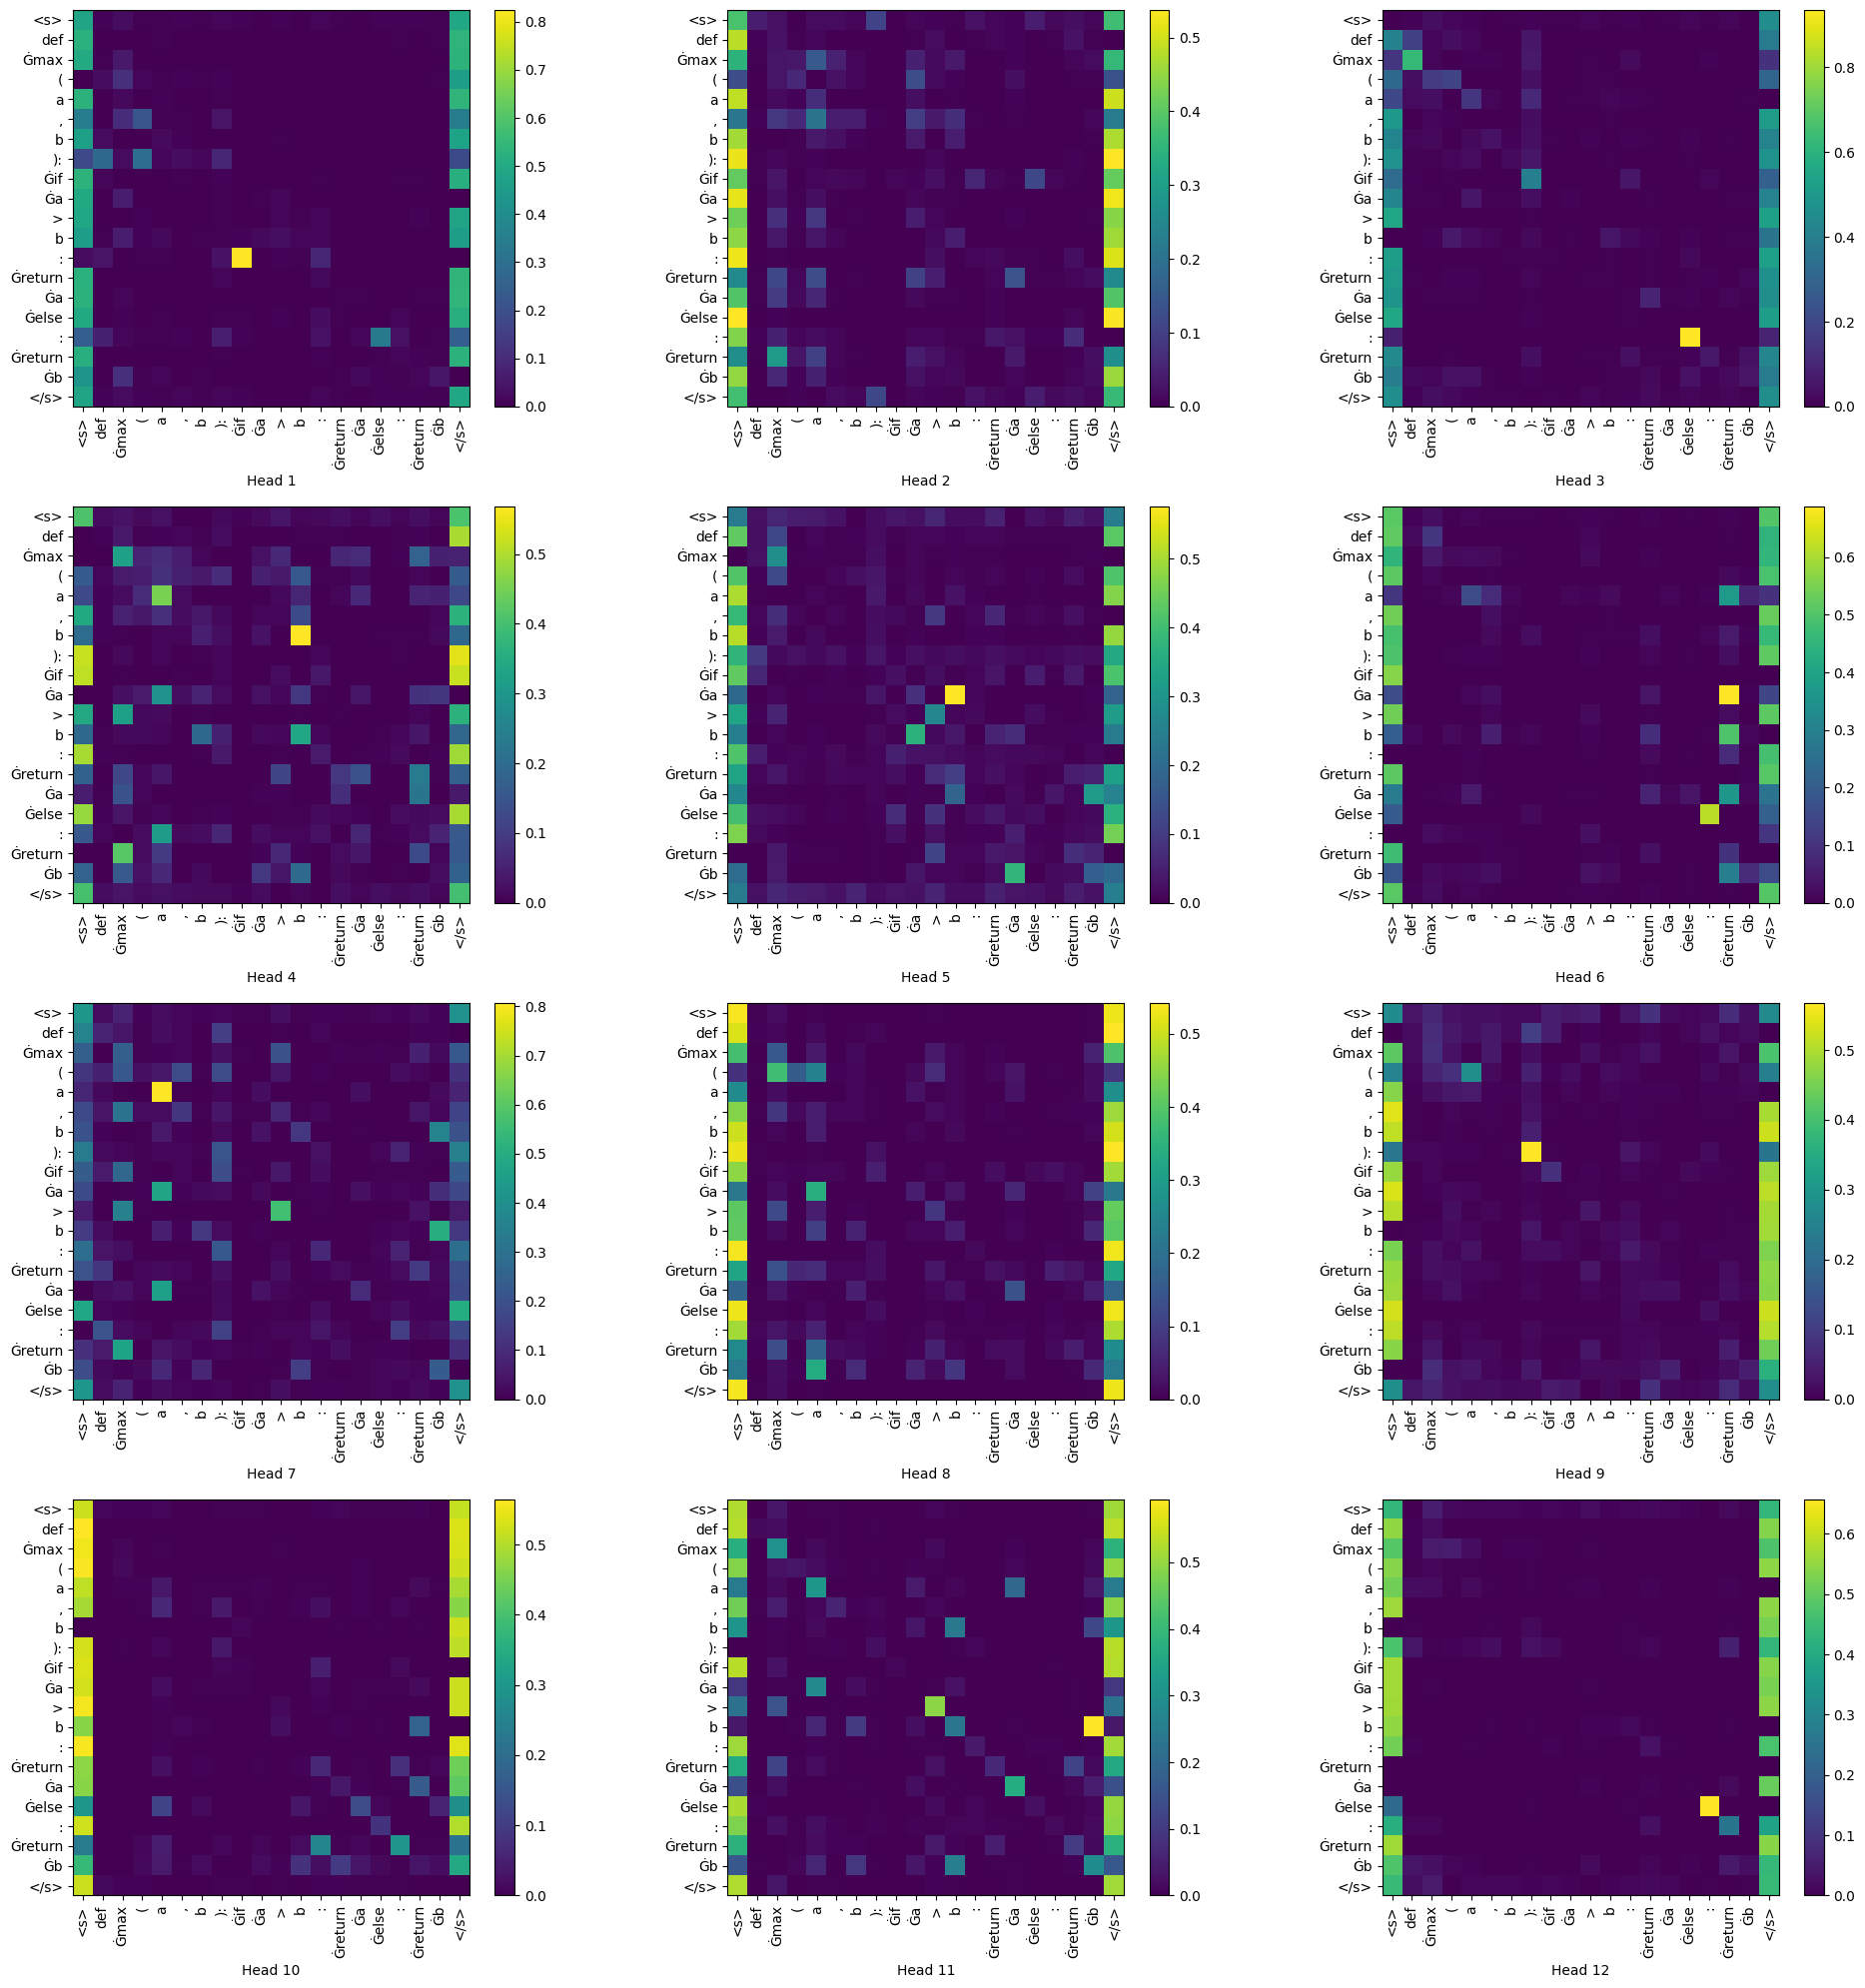

In [12]:
visualize_token2token_scores(output_attentions_all[layer].squeeze().detach().cpu().numpy())

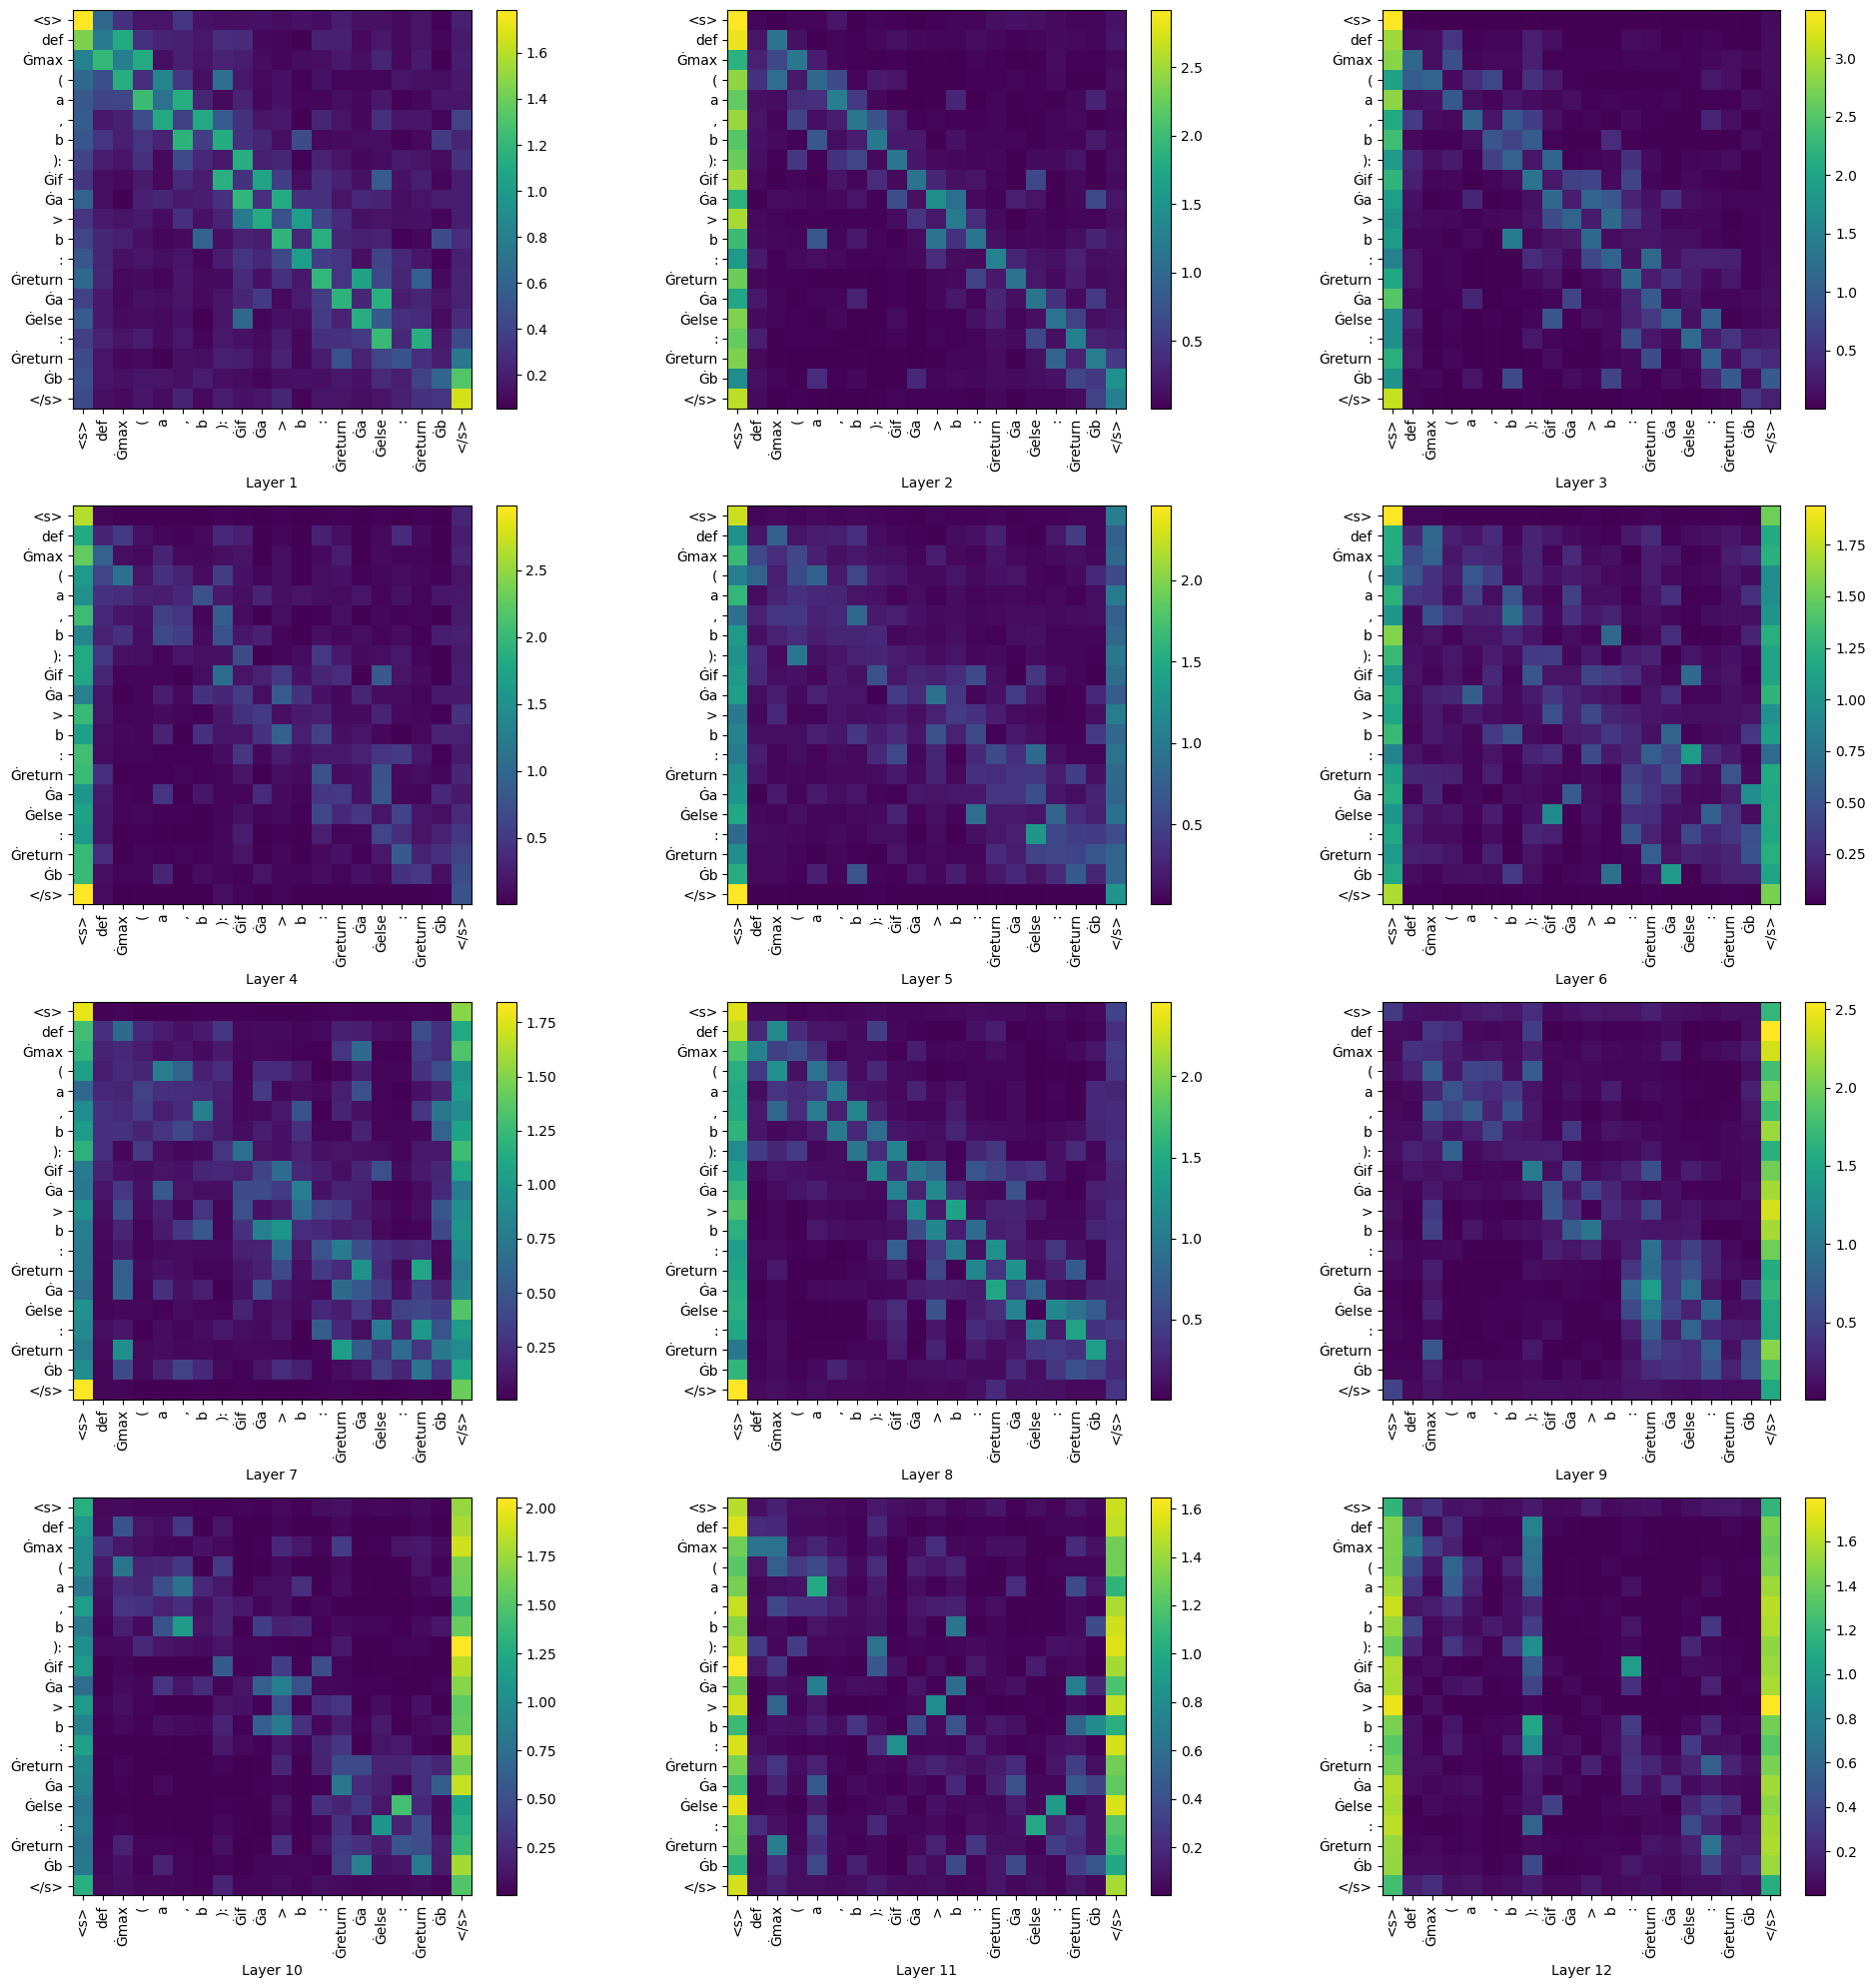

In [13]:
visualize_token2token_scores(norm_fn(output_attentions_all, dim=2).squeeze().detach().cpu().numpy(),
                             x_label_name='Layer')